In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/")

In [ ]:
!cat ./drive/MyDrive/tensors/tensors.zip* > tensors.zip

In [ ]:
!unzip tensors.zip

Streaming output truncated to the last 5000 lines.
  inflating: tensors/data5499        
  inflating: tensors/data55          
  inflating: tensors/data550         
  inflating: tensors/data5500        
  inflating: tensors/data5501        
  inflating: tensors/data5502        
  inflating: tensors/data5503        
  inflating: tensors/data5504        
  inflating: tensors/data5505        
  inflating: tensors/data5506        
  inflating: tensors/data5507        
  inflating: tensors/data5508        
  inflating: tensors/data5509        
  inflating: tensors/data551         
  inflating: tensors/data5510        
  inflating: tensors/data5511        
  inflating: tensors/data5512        
  inflating: tensors/data5513        
  inflating: tensors/data5514        
  inflating: tensors/data5515        
  inflating: tensors/data5516        
  inflating: tensors/data5517        
  inflating: tensors/data5518        
  inflating: tensors/data5519        
  inflating: tensors/data552         

In [ ]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset
import torch.utils.data as data
# Torchvision library
import torchvision
import gc

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

###
from torchsummary import summary
from skimage.transform import resize
from skimage import color
from skimage import io
import re
from google.colab import files
import wandb

####
from transformers import ViTForImageClassification
from transformers import ViTImageProcessor


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Utils functions

In [ ]:
def lab_to_rgb(img_l, img_ab):
    """
    Convert a pair of numpy arrays (l channel and ab channels) into an rgb image
    :param img_l:
    :return:
    """
    lab = np.empty([*img_l.shape[0:2], 3])
    lab[:, :, 0] = np.squeeze(((img_l + 1) * 50))
    lab[:, :, 1:] = img_ab * 127
    return color.lab2rgb(lab)


def rgb_to_lab(img):
    lab = color.rgb2lab(img).astype(np.float32)
    L =  np.expand_dims(lab[:,:,0], axis=2)
    L = 2 * L / 100 - 1
    AB = lab[:, :, 1:].transpose(2,0,1) / 127
    return L,AB


def get_image_class(filename):
    pattern = r'[0-9]'
    return re.sub(pattern, '', filename)


def format_model_name(base_name, loss):
    return f'{base_name}_{loss:.4f}'.replace(".", "_") + ".pt"


def split_dataset_sun(dataset):
    filename_lst = list()
    splits_dict = torch.load("drive/MyDrive/tensors/split_dict")
    train_ix_lst = list()
    val_ix_lst = list()
    test_ix_lst = list()

    for ix,data in enumerate(dataset):
      if data["filename"] in splits_dict["train"]:
          train_ix_lst.append(ix)
      elif data["filename"] in splits_dict["val"]:
          val_ix_lst.append(ix)
      elif data["filename"] in splits_dict["test"]:
          test_ix_lst.append(ix)
    return train_ix_lst, val_ix_lst, test_ix_lst


In [ ]:
# Compositions of transformations
transforms = torchvision.transforms.Compose([ torchvision.transforms.ToTensor()
        ])

In [ ]:
'''
#For preprocessing image to different sizes and extracting the L and AB channel

class ModelData(torch.utils.data.Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = io.imread(img_path)
        image_enc = resize(image, (256, 256))
        image_feat_extr = resize(image, (299, 299))

        L_enc, AB = rgb_to_lab(image_enc)
        L_feat_extr, _ = rgb_to_lab(image_feat_extr)


        # Scale For Feature extractor
        L_feat_extr = np.repeat(L_feat_extr,3,axis=2).transpose(2,0,1).astype(np.float32)

        # Scale for Encoder
        L_enc = np.repeat(L_enc,3,axis=2).transpose(2,0,1).astype(np.float32)


        # Build Sample Dict.
        sample = {
                 "L_feat_extr":L_feat_extr, "L_enc":L_enc, "AB":AB,
                 "RGB": image_enc, "label" : get_image_class(img_name)}

        return sample

  '''

'\nclass ModelData(torch.utils.data.Dataset):\n\n    def __init__(self, root_dir, transform=None):\n        self.root_dir = root_dir\n        self.data = os.listdir(root_dir)\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.data)\n\n    def __getitem__(self, idx):\n        img_name = self.data[idx]\n        img_path = os.path.join(self.root_dir, img_name)\n        image = io.imread(img_path)\n        image_enc = resize(image, (256, 256))\n        image_feat_extr = resize(image, (299, 299))\n\n        L_enc, AB = rgb_to_lab(image_enc)\n        L_feat_extr, _ = rgb_to_lab(image_feat_extr)\n\n\n        # Scale For Feature extractor\n        L_feat_extr = np.repeat(L_feat_extr,3,axis=2).transpose(2,0,1).astype(np.float32)\n\n        # Scale for Encoder\n        L_enc = np.repeat(L_enc,3,axis=2).transpose(2,0,1).astype(np.float32)\n\n\n        # Build Sample Dict.\n        sample = {\n                 "L_feat_extr":L_feat_extr, "L_enc":L_enc, "AB":AB,\n

In [ ]:
#For loading the object with the dataset item already preprocessed
class ModelData(torch.utils.data.Dataset):


    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_name = self.data[idx]
        file_path = os.path.join(self.root_dir, file_name)
        img_tensor = torch.load(file_path)

        return img_tensor


In [ ]:
dataset = ModelData(root_dir='tensors/', transform = None )

In [ ]:
train_ix_lst,val_ixs_lst, test_ixs_lst = split_dataset_sun(dataset)

In [ ]:
train_dataset = torch.utils.data.Subset(dataset, train_ix_lst)
val_dataset = torch.utils.data.Subset(dataset, val_ixs_lst)
test_dataset = torch.utils.data.Subset(dataset, test_ixs_lst)


In [ ]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle = True,
                                             num_workers=2)
val_iterator = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                         )



Pre-trained encoder

In [ ]:
ViT_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
ViT_model.to(device)


processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

**Encoder block**

In [ ]:
class ImgEncoder(nn.Module):

    def __init__(self):
        super(ImgEncoder, self).__init__()

        self.layers = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            # Conv2
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            # Conv3
            nn.Conv2d(128, 128, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            # Conv4
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            # Conv5
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            # Conv6
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            # Conv7
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            # Conv8
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )

    def forward(self, x):
        return self.layers(x)

Fusion block

In [ ]:
class ImgFusion(nn.Module):

    def __init__(self):
        super(ImgFusion, self).__init__()
        # In practice nothing here

    def forward(self, img1, img2):
        img2 = torch.stack([torch.stack([img2],dim=2)],dim=3)
        img2 = img2.repeat(1, 1, img1.shape[2], img1.shape[3])
        return torch.cat((img1, img2),1)

Decoder

In [ ]:
class ImgDecoder(nn.Module):

    def __init__(self):
        super(ImgDecoder, self).__init__()

        self.layers = nn.Sequential(

            # Conv1
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            # Upsample1
            nn.Upsample(scale_factor=2.0),

            # Conv2
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            # Conv3
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            # Upsample2
            nn.Upsample(scale_factor=2.0),

            # Conv4
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            # Conv5
            nn.Conv2d(32, 2, 3, stride=1, padding=1),
            nn.Tanh(),

            # Upsample3
            nn.Upsample(scale_factor=2.0),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class ColorNet(nn.Module):

    def __init__(self):
        super(ColorNet, self).__init__()
        self.encoder = ImgEncoder()
        self.fusion = ImgFusion()
        self.decoder = ImgDecoder()
        self.post_fuse = nn.Conv2d(1256, 256, 1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, img1, img2):

        # Encoder Output
        out_enc = self.encoder(img1)

        # Fusion
        temp = self.fusion(out_enc, img2)
        temp = self.post_fuse(temp)
        temp = self.relu(temp)

        return self.decoder(temp)

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0

  # Train mode
  model.train()

  for data in iterator:
    # Move Data to GPU
    enc_in = data["L_enc"].to(device)
    vit_in = data["L_vit"].to(device)
    AB = data["AB"].to(device)



    # Init. Optim. Params.
    optimizer.zero_grad()

    # Forward Prop.
    # Get Inception Output
    with torch.no_grad():
      out_vit = ViT_model(vit_in)

    # Get Network AB
    AB_pred = model(enc_in, out_vit.logits)

    # Determine Loss
    loss = criterion(AB_pred, AB)

    # Back Prop.
    loss.backward()

    # Update Weights
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()

  return epoch_loss/len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for data in iterator:
      enc_in = data["L_enc"].to(device)
      vit_in = data["L_vit"].to(device)
      AB = data["AB"].to(device)

      out_vit = ViT_model(vit_in)

      # Get Network AB
      AB_pred = model(enc_in, out_vit.logits)
      # Make Predictions

      # Compute loss
      loss = criterion(AB_pred, AB)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()

  return epoch_loss/len(iterator)

In [ ]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):
    # Initialize validation loss
  best_valid_loss = float('inf')
  # Save output losses, accs
  train_losses = []
  valid_losses = []

  for epoch in range(n_epochs):
      start_time = time.time()
      # Train
      train_loss = train(model, train_iterator, optimizer, criterion, device)
      # Validation
      valid_loss = evaluate(model, valid_iterator, criterion, device)
      # Save best model
      if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model_name = format_model_name(model_name,best_valid_loss)
        # Save model
        torch.save(model.state_dict(),
                   best_model_name)
      end_time = time.time()

      print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
      print("---------------------------------")
      print(f"Train -- Loss: {train_loss:.3f}")
      print(f"Val -- Loss: {valid_loss:.3f}")
      wandb.log({"train_loss": train_loss, "val_loss": valid_loss})


      # Save
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      torch.cuda.empty_cache()
      _ = gc.collect()


  return train_losses, valid_losses, best_model_name

In [ ]:
LR = 1e-4
WEIGHT_DECAY = 1e-6
N_EPOCHS = 50


In [ ]:
wandb.init(project="colorization",
            config = {"architecture"  : "CNN + Transformers",
                    "learning_rate" : LR,
                    "batch_size"    : BATCH_SIZE,
                    "epochs"        : N_EPOCHS,
                    "weight_decay"  : WEIGHT_DECAY

                    }
          )

wandb: Currently logged in as: josejch11 (unipd-ds). Use `wandb login --relogin` to force relogin


In [ ]:
model = ColorNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss().to(device)

In [ ]:
train_losses,  valid_losses, model_name = model_training(N_EPOCHS,
                                            model,
                                            train_iterator,
                                            val_iterator,
                                            optimizer,
                                            criterion,
                                            device,
                                            'colornet_vit')


files.download(model_name)
wandb.finish()


Epoch: 1/50 -- Epoch Time: 323.91 s
---------------------------------
Train -- Loss: 0.018
Val -- Loss: 0.009

Epoch: 2/50 -- Epoch Time: 331.65 s
---------------------------------
Train -- Loss: 0.009
Val -- Loss: 0.008

Epoch: 3/50 -- Epoch Time: 327.23 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.008

Epoch: 4/50 -- Epoch Time: 334.20 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.008

Epoch: 5/50 -- Epoch Time: 327.20 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.008

Epoch: 6/50 -- Epoch Time: 337.38 s
---------------------------------
Train -- Loss: 0.008
Val -- Loss: 0.008

Epoch: 7/50 -- Epoch Time: 341.79 s
---------------------------------
Train -- Loss: 0.007
Val -- Loss: 0.007

Epoch: 8/50 -- Epoch Time: 339.92 s
---------------------------------
Train -- Loss: 0.007
Val -- Loss: 0.007

Epoch: 9/50 -- Epoch Time: 343.16 s
---------------------------------
Train -- Loss: 0.007
Val -- Loss: 0.008



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train_loss,█▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▂▂▃▄▁▂▂▂▁▂▁▁▃▂▁▂▂▂▂▂▂▂▃▂▂▂▂▃▂▂▂▂▂▃▂
train_loss,0.00279
val_loss,0.00767


# **Inference**

In [ ]:
#model_name = "colornet_vit_0_0078.pt"

In [ ]:
best_model_dict = torch.load(model_name)
model.load_state_dict(best_model_dict)

<All keys matched successfully>

In [ ]:
sample_idx = 7
test_l_enc= dataset[sample_idx]["L_enc"].to(device)
test_l_vit = dataset[sample_idx]["L_vit"].to(device)
test_ab = torch.from_numpy(dataset[sample_idx]["AB"]).to(device)

test_l_vit = test_l_vit.unsqueeze(0)

In [ ]:
with torch.no_grad():
    out_vit = ViT_model(test_l_vit)



In [ ]:
model.eval()

with torch.no_grad():
    out_data = model(test_l_enc.unsqueeze(0), out_vit.logits)


In [ ]:
test_l_enc = np.expand_dims(test_l_enc.cpu().numpy()[0,:,:], axis=0).transpose(1,2,0)
test_ab_pred = out_data.cpu().numpy().squeeze(0).transpose(1,2,0)
rgb_test =lab_to_rgb(test_l_enc,test_ab_pred)

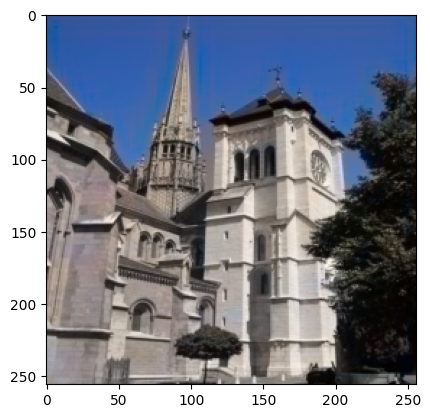

In [ ]:
plt.imshow(rgb_test) #0.0078

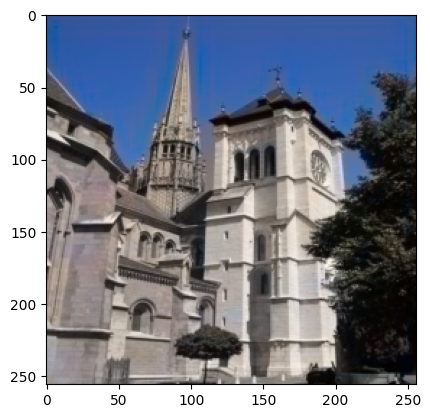

In [ ]:
plt.imshow(rgb_test) #0.0075

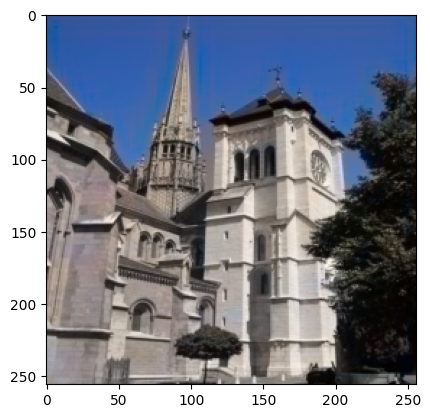

In [ ]:
plt.imshow(rgb_test) #0.0073

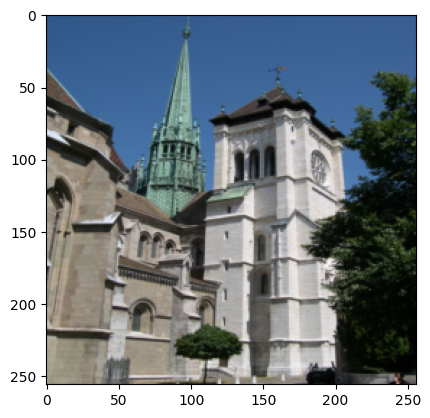

In [ ]:
ab = test_ab.permute(1,2,0).cpu().numpy()
rgb_test = lab_to_rgb(test_l_enc,ab)
plt.imshow(rgb_test)